In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.framework.python.ops import add_arg_scope

def depthwise_conv2d(input_tensor, kernel_size, strides=[1, 1], padding='VALID', activation_fn=None, weights_regularizer=None, scope=None):
    axis = 3
    shape = [-1] + [int(s) for s in input_tensor.shape[1:]]

    splited = [tf.reshape(t, [shape[0], shape[1], shape[2], 1]) for t in tf.unstack(input_tensor, axis=axis)]
    
    splited_out = []
    for i, t in enumerate(splited):
        o = slim.layers.conv2d(t, 1, [3, 3], padding=padding,
                               activation_fn=activation_fn, weights_regularizer=weights_regularizer, scope=scope+'_'+str(i))
        splited_out.append(tf.squeeze(o, [axis]))
    
    result = tf.stack(splited_out, axis=axis)
    return result

def pointwise_conv2d(input_tensor, filters, activation_fn=None, weights_regularizer=None, scope=None):
    return slim.layers.conv2d(input_tensor, filters, [1, 1], padding='SAME',
                              activation_fn=activation_fn, weights_regularizer=weights_regularizer, scope=scope)

@add_arg_scope
def separable_conv2d(input_tensor, filters, kernel_size, strids=[1, 1], padding='VALID', activation_fn=None, weights_regularizer=None, scope=None):
    scope = scope if not scope is None else 'separable_conv2d'
    l = depthwise_conv2d(input_tensor, kernel_size, strids, padding,
                         weights_regularizer=weights_regularizer, scope=scope+'_depthwise')
    l = slim.batch_norm(l, scope=scope+'_bn')
    l = pointwise_conv2d(l, filters, activation_fn, 
                         weights_regularizer=weights_regularizer, scope=scope+'_pointwise')
    return l

In [2]:
import functools
import tensorflow as tf
import tensorpack.tfutils.symbolic_functions as symbf
from core.model import ModelMNIST10x10_base
from core.hessian import hessians_highrank

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.MomentumOptimizer(1.0, 0.9, use_nesterov=True)):
        self.batch_ratio = max(1.0, 1.0 * batch_size / 50000.0)
        super(Implement, self).__init__(batch_size, opt)

    def _build_graph(self, inputs, activation):
        image, label, vector = inputs
        
        with slim.arg_scope([separable_conv2d], weights_regularizer=slim.l2_regularizer(1e-4), activation_fn=activation), \
             slim.arg_scope([slim.layers.fully_connected], weights_regularizer=slim.l2_regularizer(1e-5)):
            l = separable_conv2d(image, 8, [3, 3], padding='SAME', scope='conv0' ) # 10x10
            l = slim.layers.max_pool2d(l, [2, 2], scope='pool0') # 5x5
            l = slim.batch_norm(l, scope='bn0')
            l = separable_conv2d(l, 8, [3, 3], scope='conv1') # 3x3
            l = slim.batch_norm(l, scope='bn1')
            l = separable_conv2d(l, 8, [3, 3], scope='conv2') # 1x1
            l = slim.batch_norm(l, scope='bn2')
            l = slim.layers.flatten(l, scope='flatten')
            logits = slim.layers.fully_connected(l, 10, activation_fn=None, scope='fc0')

        # Currently there is no way to take the second derivative of sparse_softmax_cross_entropy_with_logits due to the fused implementation
        #cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=vector)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')
        tf.summary.scalar('cost', cost)

        prob = tf.nn.softmax(logits, name='prob')
        accuracy = symbf.accuracy(logits, label, topk=1)
        tf.summary.scalar('accuracy', accuracy)
        return prob, cost, accuracy

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        
        for l, g, v in zip(range(len(grads)), grads, var_refs):
            delta = g
            tf.summary.histogram('{}'.format(v.name.replace(':', '_')), v)
            tf.summary.histogram('{}/gradient'.format(v.name.replace(':', '_')), g)
            tf.summary.histogram('{}/delta'.format(v.name.replace(':', '_')), delta)
            
        return grads

In [3]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)

model = Implement(batch_size=128*100)

[1204 22:38:46 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1204 22:38:46 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.


In [4]:
from core.utils import loop

%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
history = loop(sess, model, 30, './summary/7_1_separatable_first_order_optimization')

env: CUDA_VISIBLE_DEVICES=0
[INFO] session initialized
[INFO] [0000] [train] cost:0.674 accuracy:0.125 elapsed:2.276sec [valid] cost:0.461 accuracy:0.174 elapsed:0.091sec
[INFO] [0001] [train] cost:0.375 accuracy:0.213 elapsed:0.367sec [valid] cost:0.311 accuracy:0.237 elapsed:0.018sec
[INFO] [0002] [train] cost:0.322 accuracy:0.261 elapsed:0.371sec [valid] cost:0.323 accuracy:0.258 elapsed:0.012sec
[INFO] [0003] [train] cost:0.305 accuracy:0.323 elapsed:0.339sec [valid] cost:0.283 accuracy:0.334 elapsed:0.012sec
[INFO] [0004] [train] cost:0.277 accuracy:0.380 elapsed:0.368sec [valid] cost:0.269 accuracy:0.389 elapsed:0.012sec
[INFO] [0005] [train] cost:0.263 accuracy:0.421 elapsed:0.358sec [valid] cost:0.253 accuracy:0.428 elapsed:0.012sec
[INFO] [0006] [train] cost:0.249 accuracy:0.437 elapsed:0.339sec [valid] cost:0.240 accuracy:0.469 elapsed:0.012sec
[INFO] [0007] [train] cost:0.237 accuracy:0.481 elapsed:0.373sec [valid] cost:0.228 accuracy:0.511 elapsed:0.012sec
[INFO] [0008] [tr

average elapsed time train:0.341667sec valid:0.012627sec


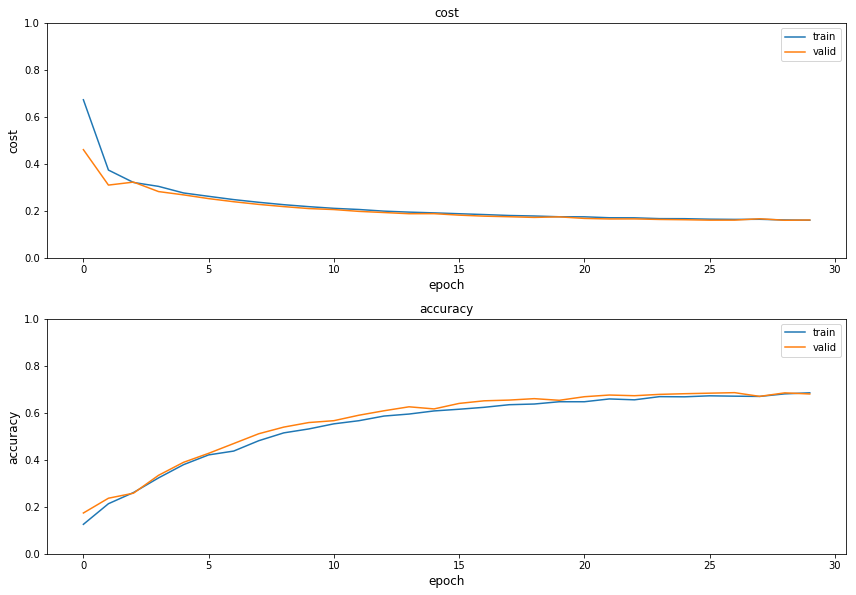

In [5]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)